### Show 1D spectrum methods

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import grizli
print(grizli.__version__)

from grizli import utils, multifit
utils.set_warnings()

0.10.0


In [2]:
# Outputs from the ERS demo in Grizli-Pipeline.ipynb
mb = multifit.MultiBeam('j033216m2743_00161.beams.fits', fcontam=0.2, sys_err=0.02, 
                        min_sens=0.05, MW_EBV=-1, 
                        group_name='j033216m2743 (ERS demo)')

msg = '\nID={0}\nRA, DEC = {1:.5f} {2:.5f}\ncomputed S&F E(B-V): {3:.4f}'
print(msg.format(mb.id, mb.ra, mb.dec, mb.MW_EBV))

1 ib6o23rsq_flt.fits G141
2 ib6o21qmq_flt.fits G102
3 ib6o23ruq_flt.fits G141
4 ib6o21r6q_flt.fits G102
5 ib6o21qoq_flt.fits G102
6 ib6o23ryq_flt.fits G141
7 ib6o21r8q_flt.fits G102
8 ib6o23s0q_flt.fits G141

ID=161
RA, DEC = 53.06576 -27.72050
computed S&F E(B-V): 0.0081


In [3]:
# The 2D models are generated by first interpolating the templates to the nominal 
# wavelength grid.  This defines the grism spectrum for a single pixel, and the 
# 2D model is constructed by adding up these 1D pixels scaled by the pixel fluxes in 
# the direct image.
# 
# As a result, for the redshift fits `fwhm` should be large enough so that a line 
# contributes to multiple spectral pixels to avoid aliasing in the redshift PDF.
fwhm = 1100. # ~ 46 A / 1.1 um * c for G141

# Templates to fit.  This is just a dictrionary of `utils.SpectrumTemplate` objects 
# with string keys for the template names could, e.g., be a single FSPS model
templ = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True)

# Get template fit at a given redshift
#
# NB: Bounded least squares is the new default minimizer where the 
#     bounds are non-negative coefficients for the continuum templates and free
#     normalization of the lines (with noise you can have a negative line flux)
z = 1.7418
tfit = mb.template_at_z(z, fitter='bounded')

Plot with y units flam
Plot with y units uJy
Plot with y units eps
Plot with y units resid


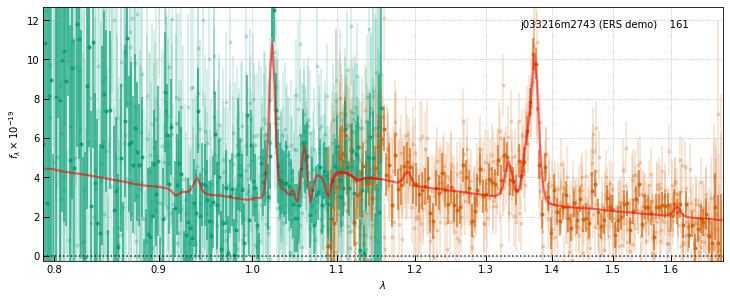

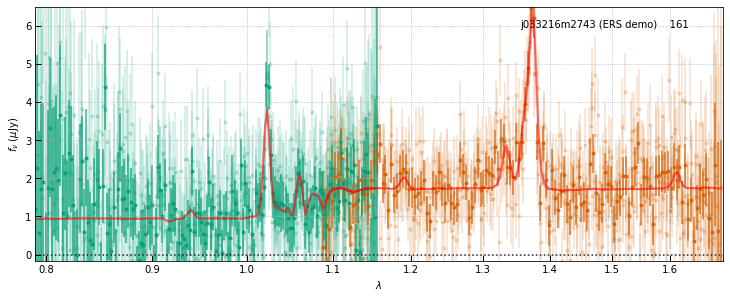

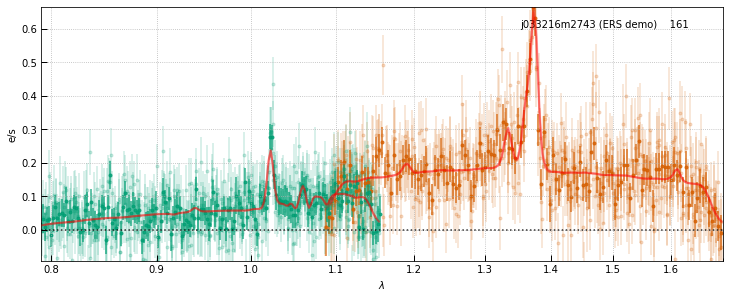

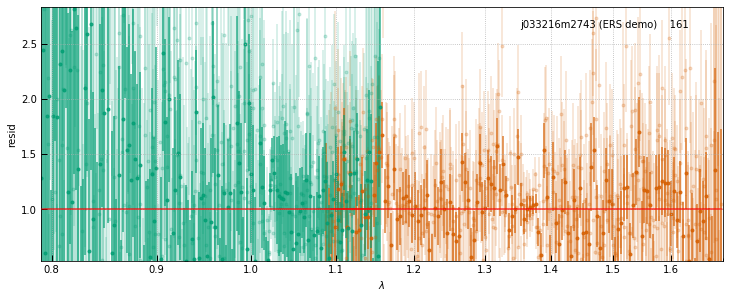

In [4]:
fs = [10,4] # Figure size

for units in ['flam', 'uJy', 'eps', 'resid']:
    print('Plot with y units {0}'.format(units))
    fig = mb.oned_figure(tfit=tfit, bin=1, units=units, figsize=fs)

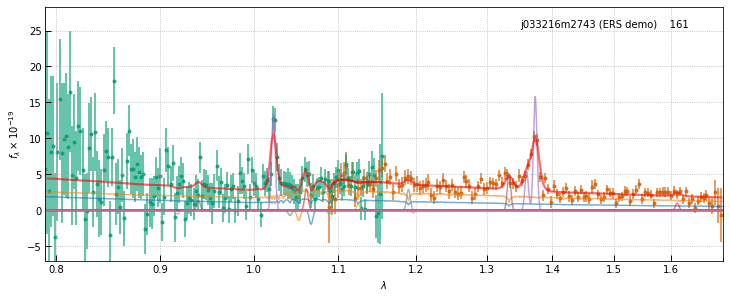

In [5]:
# Show each component of the template combinations 
# (at template resolution before generating the 2D model)
show_individual_templates=True

fig = mb.oned_figure(tfit=tfit, bin=1, units='flam', 
                     show_beams=False, 
                     show_individual_templates=show_individual_templates, 
                     figsize=fs)


Offset between x centroid and central pixel that defines 1D wavelength: 
-0.04 pix ~ -1.8 \AA (G141)


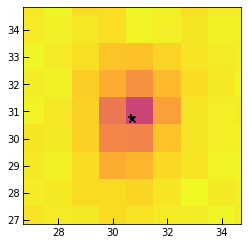

In [6]:
### Show image and compare central position to centroid

b, ref_line = mb.beams[1], 'OII' # G102
b, ref_line = mb.beams[0], 'OIII-5007' # G141

direct = b.direct['REF']

plt.imshow(direct, vmin=-0.1, vmax=5, 
           origin='lower', interpolation='Nearest',
           cmap='plasma_r')

sh = direct.shape

# center pixel sets the wavelength axis for 1D
x0, y0 = np.array(b.direct.wcs.all_world2pix([mb.ra], [mb.dec], 0)).flatten()

dx = 4
plt.xlim(x0-dx, x0+dx); plt.ylim(y0-dx, y0+dx)
plt.scatter(x0, x0, marker='x', color='k', label='Defined center')

# Windowed centroid
yp, xp = np.indices(sh)
R = np.sqrt((xp-x0)**2+(yp-y0)**2)
mask = R < 4
xc = (xp*direct)[mask].sum()/direct[mask].sum()
yc = (yp*direct)[mask].sum()/direct[mask].sum()

plt.scatter(xc, yc, marker='+', color='k', label='Centroid')

dx = xc-x0
dw = dx*np.diff(b.wave)[0]

print("""
Offset between x centroid and central pixel that defines 1D wavelength: 
{0:.2f} pix ~ {1:.1f} \AA ({2})""".format(dx, dw, b.grism.filter))

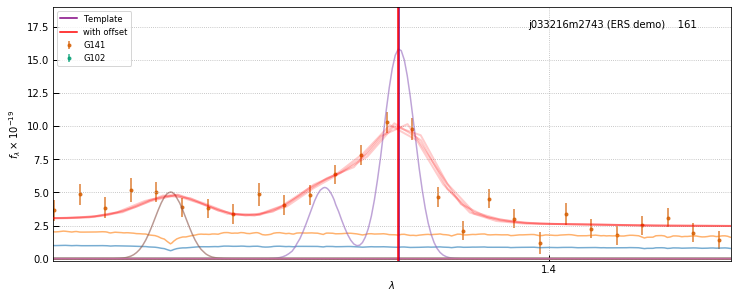

In [7]:
# Zoom in figure.  In this case the offset is very small
fig = mb.oned_figure(tfit=tfit, bin=1, units='flam', 
                     show_beams=False, show_individual_templates=True, 
                     figsize=fs)

ax = fig.gca()
ax.set_ylim(-0.2, 19)

xerr = np.abs(dw)/2/1.e4

lx = utils.get_line_wavelengths()[0][ref_line][0]*(1+z)/1.e4

ax.set_xlim(lx-0.06, lx+0.06)

ly = 17

ax.plot(lx*np.ones(2), ax.get_ylim(), color='purple', label='Template')
ax.plot((lx+dw/1.e4)*np.ones(2), ax.get_ylim(), color='r', label='with offset')
ax.legend(loc='upper left')

(0, 1.5e-18)

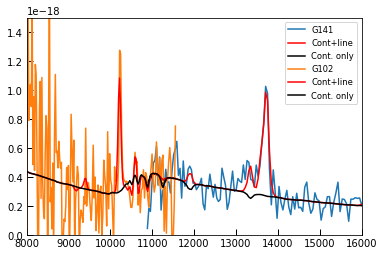

In [8]:
# If you don't want the spectrum but just want the "convolved" model
sp = mb.oned_spectrum(tfit=tfit, bin=1)

plot_flam = True

for grism in sp:
    if plot_flam:
        # To convert to F-lambda units, divide by the 
        # "flat" array, which is an extraction for a flat-flambda model
        # with f_lambda = 1 erg/s/cm2/A.  
        to_flam = 1./sp[grism]['flat']
    else:
        to_flam = 1
        
    plt.plot(sp[grism]['wave'], sp[grism]['flux']*to_flam, label=grism)
    plt.plot(sp[grism]['wave'], sp[grism]['line']*to_flam, label='Cont+line', color='r')
    plt.plot(sp[grism]['wave'], sp[grism]['cont']*to_flam, label='Cont. only', color='k')
    
plt.legend()
plt.xlim(8000,1.6e4)
plt.ylim(0,1.5e-18)
